<a href="https://www.kaggle.com/code/mohamedyosef101/energy-consumption-time-series-forecasting?scriptVersionId=145999256" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Energy Consumption - Time Series Forecasting
Our goal in this project is to use the hourly power consumption data to predict the PJME in the future. This is done by developing a model that can be used to predict future values based on the past values of the time series.

---

**DATA**: **[The hourly energy consumption data](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)** comes from PJM's website and are in megawatts (MW). 

**GitHub repo**: [mohamedyosef101/energy-time-series-forecasting](https://github.com/mohamedyosef101/energy-time-series-forecasting)

---

![earth](https://github.com/mohamedyosef101/energy-time-series-forecasting/assets/118842452/e4fce3fe-174f-4e0c-b190-2f5602110ee7)

# Step 0: Set it up
through 3 easy steps:
* Import the libraries.
* Customize the style.
* Load the data.

In [1]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# customize the style
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = 12

# load the data
filepath = '../input/hourly-energy-consumption/PJME_hourly.csv'
df = pd.read_csv(filepath)

print("Now, you're ready for step one")

Now, you're ready for step one


# Step 1: Explore the data
To better understand the data, I need to create a graph to see the change in PJM Energy over time.

In [2]:
# turn data to datetime
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

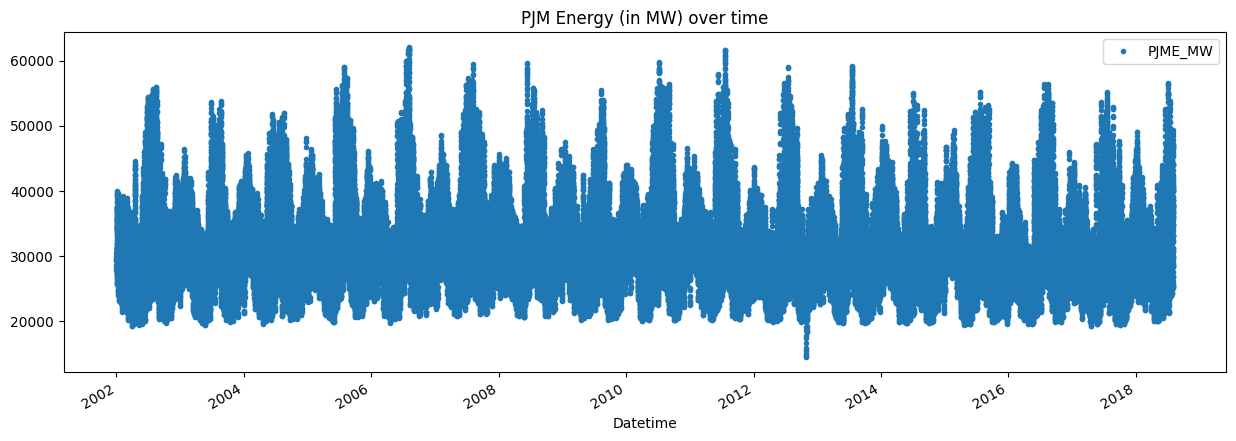

In [3]:
# create the plot
df.plot(style='.',
        figsize=(15, 5),
        title='PJM Energy (in MW) over time')
plt.show()

# Step 2: Split the data
Everything prior to January 2015 will be our training data and keep our test data as the following dates.


In [4]:
# train / test split
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

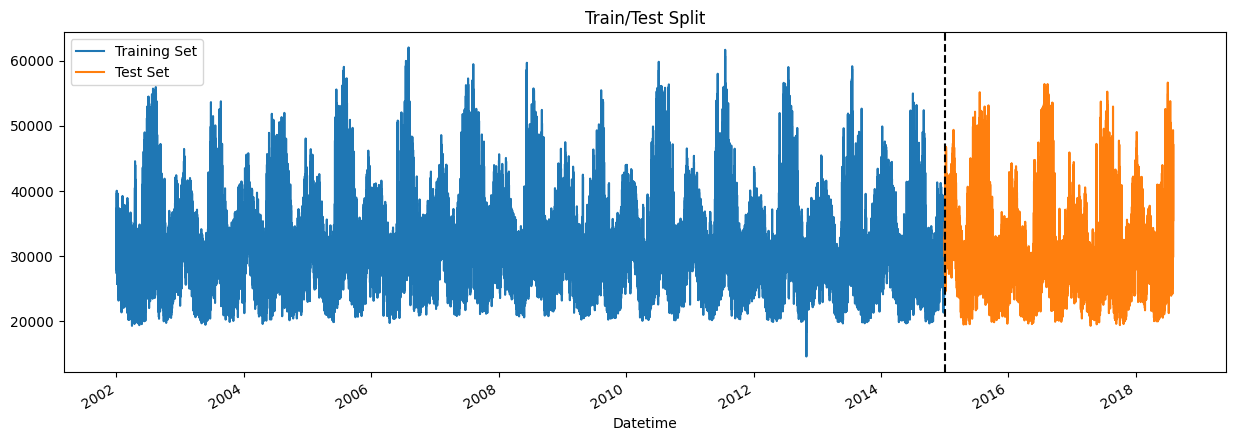

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Step 3: Feature Engineering
We're going to create some time features using the `Datetime` index. After that, we'll explore the distributions of `Hourly` and `Monthly` megawatt usage.

In [6]:
# feature creation
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

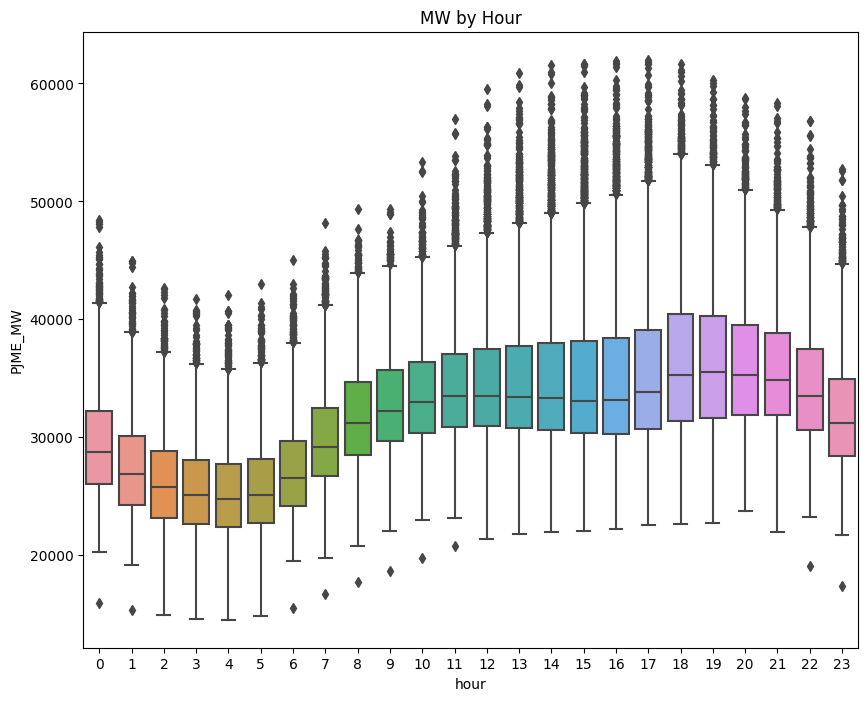

In [7]:
# visualize the hourly Megawatt
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

We can see here that after midnight, the use of energy go down and it gets higher from around 6AM to 6PM and then go down again.

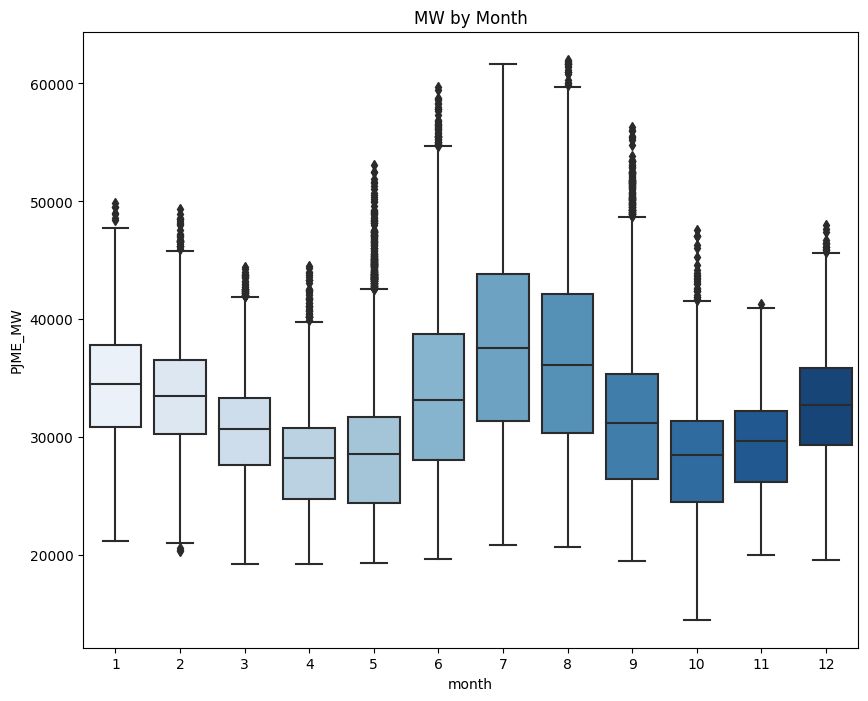

In [8]:
# viaualize the monthly Megawatt
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

The monthly usage tends to peak here two times in the winter season, then in the fall and sprint it has lower and another peak in the middle of summer.

# Step 4: Modelling
`XGBoost` is good and reliable model for regression and time series analysis as well. Also, for the metrics, we'll use `mean squared error`.

### 4.1 Prepare the data

In [9]:
# preprocessing
train = create_features(train)
test = create_features(test)

features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
target = 'PJME_MW'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

### 4.2 Build the model

In [10]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# build the regression model
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[14:48:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21569	validation_1-rmse:11743.75114
[200]	validation_0-rmse:5835.12466	validation_1-rmse:5365.67709
[300]	validation_0-rmse:3915.75557	validation_1-rmse:4020.67023
[400]	validation_0-rmse:3443.16468	validation_1-rmse:3853.40423
[500]	validation_0-rmse:3285.33804	validation_1-rmse:3805.30176
[600]	validation_0-rmse:3201.92936	validation_1-rmse:3772.44933
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91108
[800]	validation_0-rmse:3109.24248	validation_1-rmse:3733.89713
[900]	validation_0-rmse:3079.40079	validation_1-rmse:3725.61224
[999]	validation_0-rmse:3052.73503	validation_1-rmse:3722.92257


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

### 4.3 Features importance
We need to see how much these features were used in each of the trees built by `XGBoost` model.

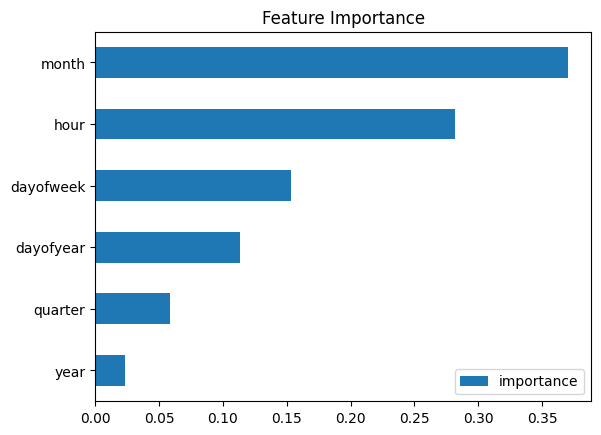

In [11]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Step 5: Forecasting on test data
compare the prediction with the actual values.

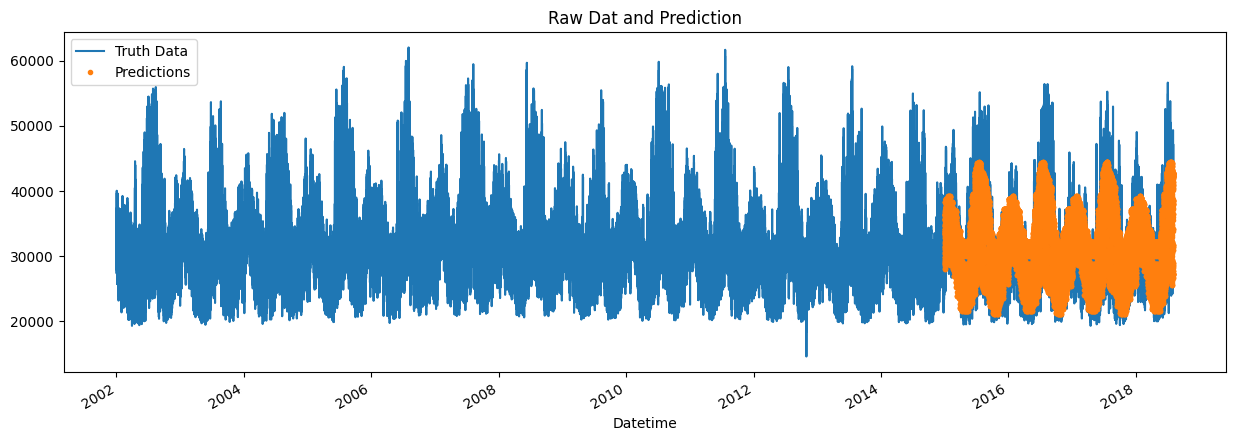

In [12]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [13]:
# Score (RMSE)
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3721.75


### That's all for now. Thanks for your time!

# Acknowledegments
* Great walk through [Time Series Forecasting with XGBoost](https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt) by Rob Mulla
* Useful video explaining [what is Time Series Analysis](https://youtu.be/GE3JOFwTWVM?si=YrK_rY1nNUwYljHF) by IBM Technology.

<div><br></div>

<div>
	<hr>
	<p> 🔔 Follow me for more <b>Data Science, User Experience (UX), and Machine Learning</b> content.</p>
	<hr>
</div>
<p>&copy; Created by <b>MohamedYosef101</b> | 
	<a href="https://linkedin.com/in/mohamedyosef101">LinkedIn</a> &centerdot;
	<a href="https://medium.com/in/@mohamedyosef101">Medium</a> &centerdot;
	<a href="https://github.com/mohamedyosef101">GitHub</a>
</p>